In [5]:
from IPython.display import display, HTML
import pandas as pd
import constants as C
import pandasql as pql
import tqdm

Q = lambda q: pql.sqldf(q, globals())
pd_context  = pd.option_context('display.max_rows', 40,
                                'display.max_columns', 1000,
                                'display.width', 1000,
                                'display.precision', 4)
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [6]:
df = pd.read_csv("fights.csv", keep_default_na=True)
df = df.sort_values(by=['datetime']).reset_index(drop=True).fillna(0)
with pd_context:
  print(df)

              fight_id    datetime  label  is_draw            red_id  red_kd  red_ss  red_ss_attempted  red_total  red_total_attempted  red_td  red_td_attempted  red_sub_attempted  red_control_min  red_control_sec  red_ss_head  red_ss_head_attempted  red_ss_body red_ss_body_attempted  red_ss_leg red_ss_leg_attempted  red_ss_distance red_ss_distance_attempted  red_ss_clinch  red_ss_clinch_attempted  red_ss_ground  red_ss_ground_attempted           blue_id  blue_kd  blue_ss  blue_ss_attempted  blue_total  blue_total_attempted  blue_td  blue_td_attempted  blue_sub_attempted  blue_control_min  blue_control_sec  blue_ss_head  blue_ss_head_attempted  blue_ss_body  blue_ss_body_attempted  blue_ss_leg  blue_ss_leg_attempted  blue_ss_distance  blue_ss_distance_attempted  blue_ss_clinch  blue_ss_clinch_attempted  blue_ss_ground  blue_ss_ground_attempted
0     c53325be8ce33b8b   763365600      1        0  6ceff86fae4f6b3b       0       3                 5       20.0                 25.0     0.0  

In [59]:
def historical_feature(df, group, n=None):
  assert group in {"red", "blue"}, "group should be one of {red, blue}"
  columns = [c.format(group) for c in C.FIGHT_UNFORMATTED_COLUMNS]
  tmp = df[[f"{group}_id", "datetime"] + columns].set_index("datetime")
  prefix = f"{group}_{n}n"
  if n is None:  # full historical feature
    prefix = f"{group}_all_time"
    tmp = tmp.groupby(f"{group}_id").expanding(min_periods=1).agg({
      k: ["mean", "std", "min", "median", "max"]
      for k in columns
    })
  elif n == 1:  # previous value only
    tmp = tmp.groupby(f"{group}_id").rolling(n, closed='left').mean()
  else:  # previous n values
    tmp = tmp.groupby(f"{group}_id").rolling(n, min_periods=1, closed='left').agg({
      k: ["mean", "std", "min", "median", "max"]
      for k in columns
    })
  tmp = pd.DataFrame(tmp)
  if n != 1:
    tmp.columns = [ "_".join(col) for col in tmp.columns.values ]
  tmp.columns = [ col.replace(group, prefix) for col in tmp.columns ]
  return tmp.reset_index().fillna(0)

In [66]:
corr = pd.merge(historical_feature(df, "red", n=5), df[["red_id", "datetime", "label"]], on=["red_id", "datetime"]).corr(numeric_only=True)

<AxesSubplot: >

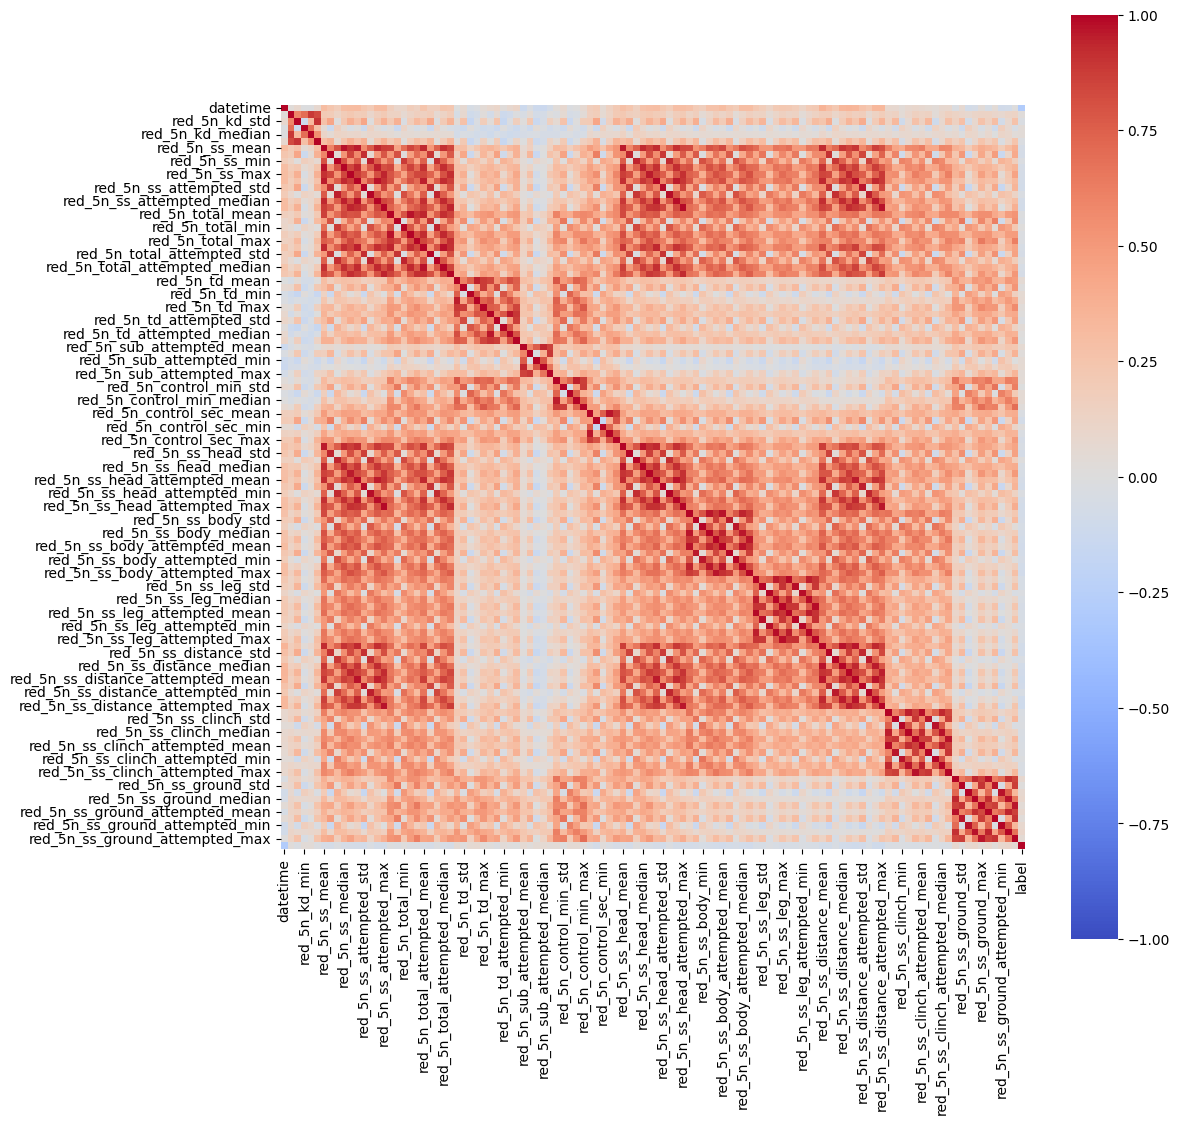

In [67]:
import matplotlib.pyplot as plt
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 12))
sb.heatmap(corr, cmap="coolwarm", square=True, vmin=-1, vmax=1)

In [6]:
def percent_features(df):
  temp = df.copy()
  temp["red_ss_percent"] = (df.red_ss / df.red_ss_attempted).fillna(0)
  temp["red_total_percent"] = (df.red_total / df.red_total_attempted).fillna(0)
  temp["red_td_percent"] = (df.red_td / df.red_td_attempted).fillna(0)
  temp["red_ss_head_percent"] = (df.red_ss_head /
                                 df.red_ss_head_attempted).fillna(0)
  temp["red_ss_body_percent"] = (df.red_ss_body /
                                 df.red_ss_body_attempted).fillna(0)
  temp["red_ss_leg_percent"] = (df.red_ss_leg /
                                df.red_ss_leg_attempted).fillna(0)
  temp["red_ss_distance_percent"] = (df.red_ss_distance /
                                     df.red_ss_distance_attempted).fillna(0)
  temp["red_ss_clinch_percent"] = (df.red_ss_clinch /
                                   df.red_ss_clinch_attempted).fillna(0)
  temp["red_ss_ground_percent"] = (df.red_ss_ground /
                                   df.red_ss_ground_attempted).fillna(0)
  temp["blue_ss_percent"] = (df.blue_ss / df.blue_ss_attempted).fillna(0)
  temp["blue_total_percent"] = (df.blue_total /
                                df.blue_total_attempted).fillna(0)
  temp["blue_td_percent"] = (df.blue_td / df.blue_td_attempted).fillna(0)
  temp["blue_ss_head_percent"] = (df.blue_ss_head /
                                  df.blue_ss_head_attempted).fillna(0)
  temp["blue_ss_body_percent"] = (df.blue_ss_body /
                                  df.blue_ss_body_attempted).fillna(0)
  temp["blue_ss_leg_percent"] = (df.blue_ss_leg /
                                 df.blue_ss_leg_attempted).fillna(0)
  temp["blue_ss_distance_percent"] = (df.blue_ss_distance /
                                      df.blue_ss_distance_attempted).fillna(0)
  temp["blue_ss_clinch_percent"] = (df.blue_ss_clinch /
                                    df.blue_ss_clinch_attempted).fillna(0)
  temp["blue_ss_ground_percent"] = (df.blue_ss_ground /
                                    df.blue_ss_ground_attempted).fillna(0)
  temp = temp.drop([
      "red_ss", "red_ss_attempted", "red_total", "red_total_attempted",
      "red_td", "red_td_attempted", "red_ss_head", "red_ss_head_attempted",
      "red_ss_body", "red_ss_body_attempted", "red_ss_leg",
      "red_ss_leg_attempted", "red_ss_distance", "red_ss_distance_attempted",
      "red_ss_clinch", "red_ss_clinch_attempted", "red_ss_ground",
      "red_ss_ground_attempted", "blue_ss", "blue_ss_attempted", "blue_total",
      "blue_total_attempted", "blue_td", "blue_td_attempted", "blue_ss_head",
      "blue_ss_head_attempted", "blue_ss_body", "blue_ss_body_attempted",
      "blue_ss_leg", "blue_ss_leg_attempted", "blue_ss_distance",
      "blue_ss_distance_attempted", "blue_ss_clinch",
      "blue_ss_clinch_attempted", "blue_ss_ground", "blue_ss_ground_attempted"
  ], axis=1)
  return temp

def control_time(df):
  temp = df.copy()
  temp["red_control_time"] = 60 * df.red_control_min + df.red_control_sec
  temp["blue_control_time"] = 60 * df.blue_control_min + df.blue_control_sec
  temp = temp.drop([
      "red_control_min", "red_control_sec", "blue_control_min",
      "blue_control_sec"
  ], axis=1)
  return temp

def z_score(df):
  temp = df.copy()
  for column in temp.columns:
    if temp[column].dtype != 'object' and column not in ('datetime', 'is_draw', 'label'):
      std = temp[column].std()
      if std == 0:
        std = 1e-6
      temp[column] = (temp[column] - temp[column].mean()) / std
  return temp
df2 = z_score(control_time(percent_features(df)))
df2

,fight_id,datetime,label,is_draw,red_id,red_kd,red_sub_attempted,blue_id,blue_kd,blue_sub_attempted,...,blue_total_percent,blue_td_percent,blue_ss_head_percent,blue_ss_body_percent,blue_ss_leg_percent,blue_ss_distance_percent,blue_ss_clinch_percent,blue_ss_ground_percent,red_control_time,blue_control_time
0,43496ff308e681a0,1567832400,0,0,49858bf46dabf6fb,-0.474963,-0.511578,447f9858ae78f921,1.776057,-0.429817,...,-0.422204,-0.681475,-1.262919,-0.775114,0.934422,0.402425,-1.341507,-0.942245,-0.814828,-0.726305
1,10b31e991c2d0d4e,1564203600,1,0,2c9d00968f818270,1.428487,-0.511578,3fa7688bfe48a493,-0.396083,-0.429817,...,-0.043675,-0.681475,0.293991,0.852458,0.648964,0.850485,-0.375509,-0.942245,-0.405126,-0.726305
2,8e51f8648840eb38,1155790800,1,0,d512d9f204059f57,-0.474963,0.591974,c4b9296214f4c09c,-0.396083,-0.429817,...,1.610674,-0.681475,-1.805214,-1.776696,-1.634698,-2.035023,-1.341507,-0.942245,-0.622942,-0.478109
3,bd5edc0bfa0db8c8,1211605200,1,0,f7a7f7118d4b01b6,1.428487,-0.511578,2f732dd9210d301f,-0.396083,2.146088,...,-0.006638,-0.681475,-1.495331,1.228051,-0.533646,-1.297375,0.606589,-0.942245,0.092740,-0.615270
4,66a99e85803efd92,1377925200,0,0,a01e84abefd85ec0,-0.474963,-0.511578,203c957eac95dd87,3.948198,-0.429817,...,-0.889416,2.309705,0.027895,0.226469,-1.634698,-0.678701,1.314987,1.043485,-0.814828,-0.654459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6872,34c39a5a5917e0ec,1511589600,1,0,9be6020024133293,-0.474963,0.591974,f1175ea3aafbf351,-0.396083,0.858136,...,-0.076405,-0.681475,0.363964,-1.776696,0.078049,-0.032834,-0.013260,1.539917,1.104030,-0.647927
6873,58b7b23b46f4ccd6,1382158800,1,0,22a92d7f62195791,-0.474963,0.591974,af90b10c785ced3e,-0.396083,-0.429817,...,-0.076405,-0.681475,0.518906,1.228051,-1.634698,0.367604,1.314987,-0.942245,-0.726664,-0.628333
6874,1d43112d98de273a,1359784800,0,0,75e5fec9f72910ef,-0.474963,0.591974,e5c9de15bb58b1c6,-0.396083,-0.429817,...,-0.606630,-0.681475,0.157376,-0.345864,0.506235,-0.076901,0.366239,-0.942245,-0.244356,-0.138472
6875,06142a1de3bbae75,1240030800,1,0,06f36cf4bd97ec77,-0.474963,-0.511578,22e47b53e4ceb27c,-0.396083,-0.429817,...,-0.370974,-0.681475,-0.255801,1.228051,-1.634698,0.300864,-0.456009,-0.942245,2.893235,-0.517298


/var/folders/pm/f17sf83x2pdby3kv7_qds1kw0000gn/T/ipykernel_4124/922173617.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df2.corr(), cmap="coolwarm", square=True, vmin=-1, vmax=1)


<AxesSubplot: >

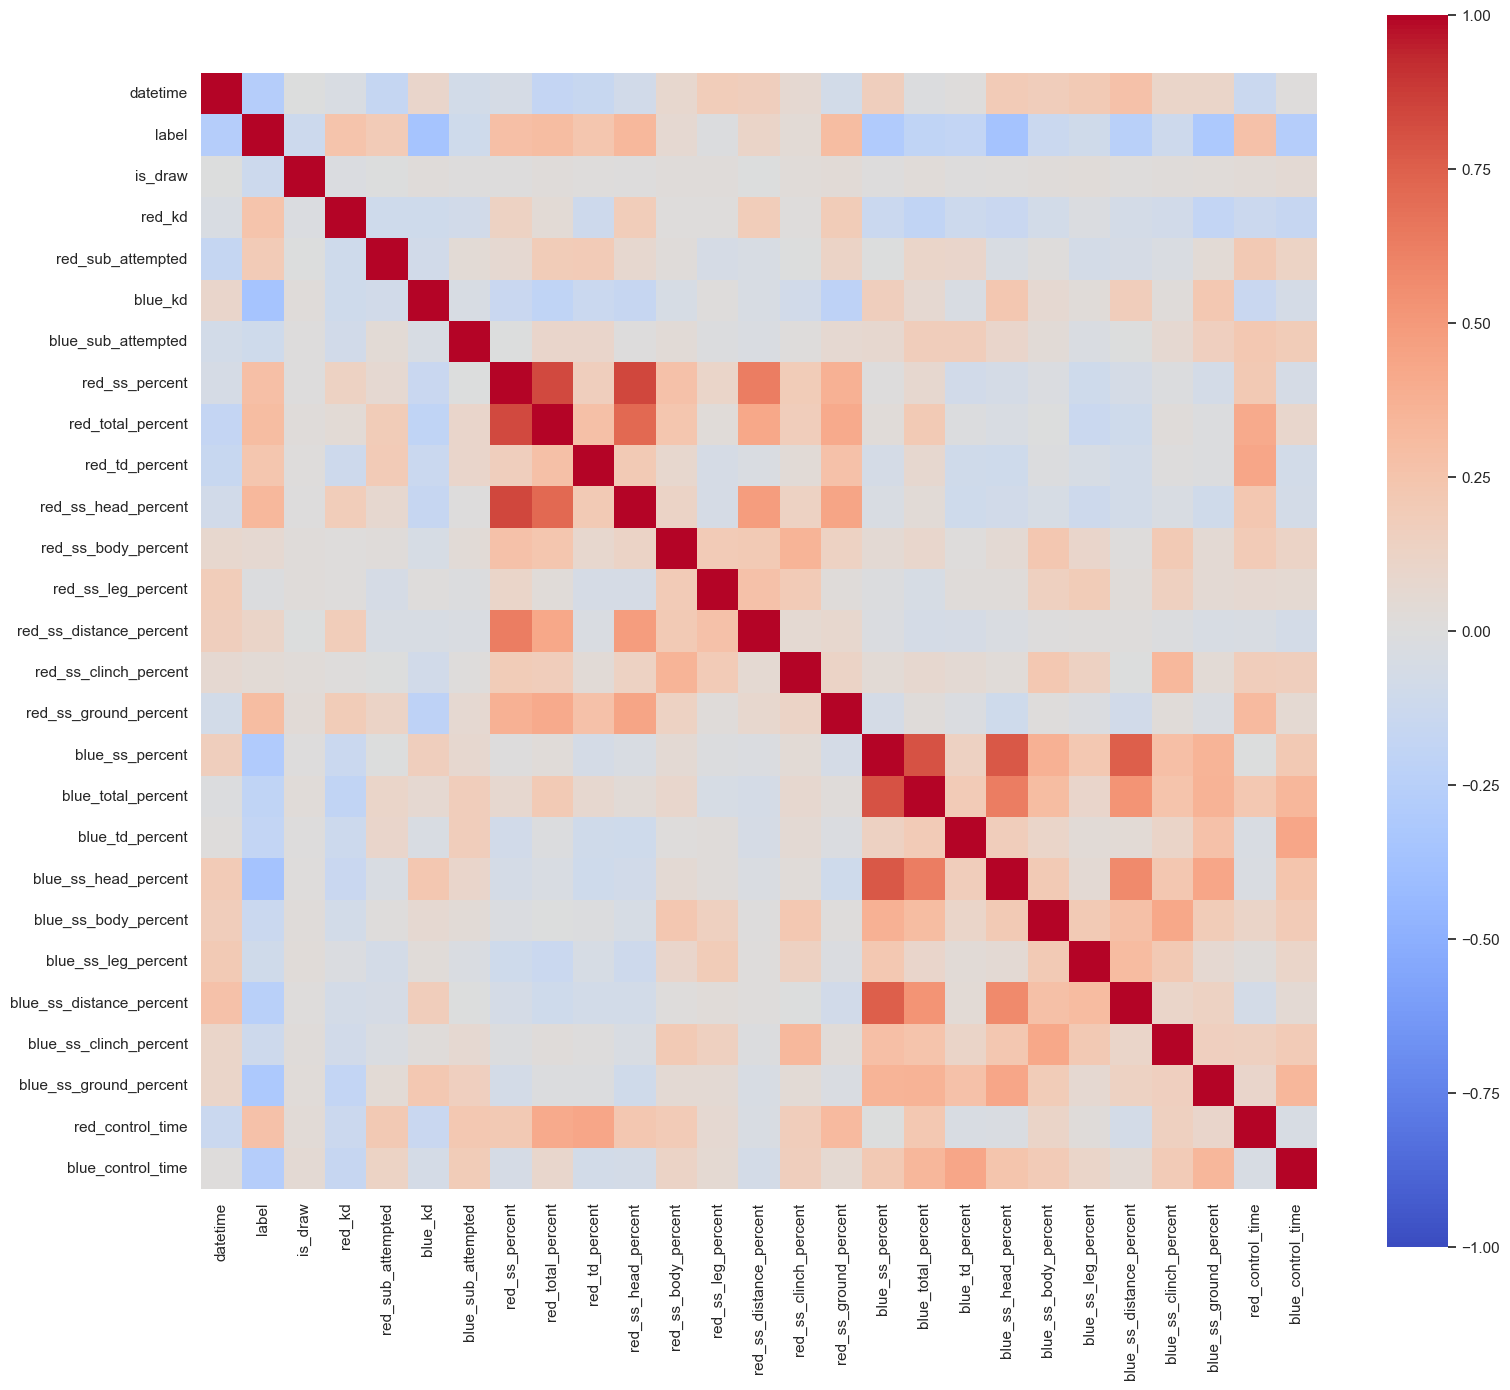

In [10]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
fig, ax = plt.subplots(figsize=(18, 16))
sb.heatmap(df2.corr(), cmap="coolwarm", square=True, vmin=-1, vmax=1)

/var/folders/pm/f17sf83x2pdby3kv7_qds1kw0000gn/T/ipykernel_4124/1786653584.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


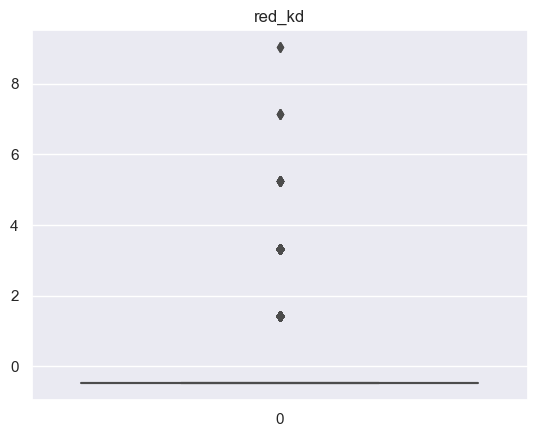

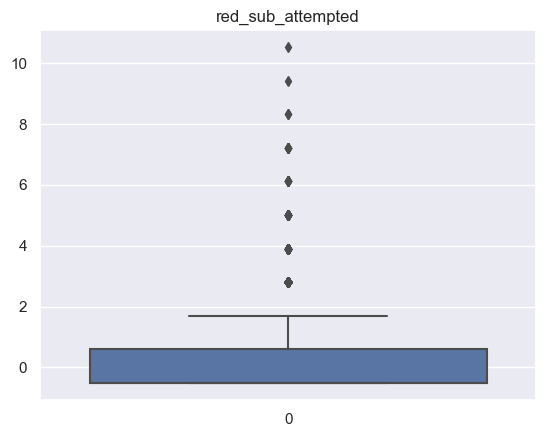

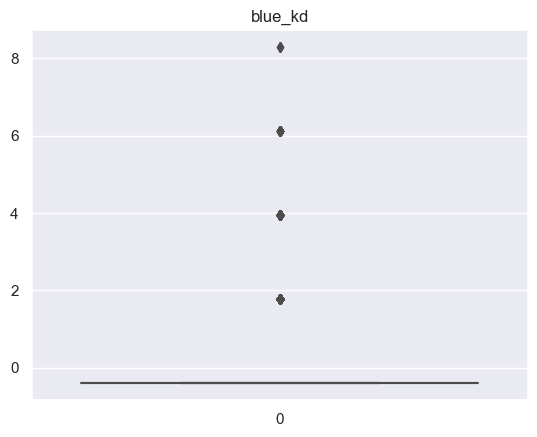

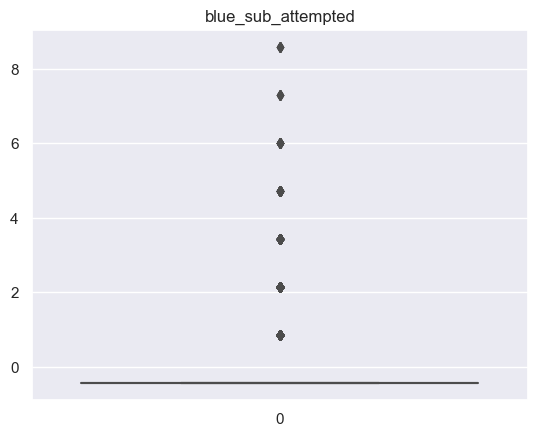

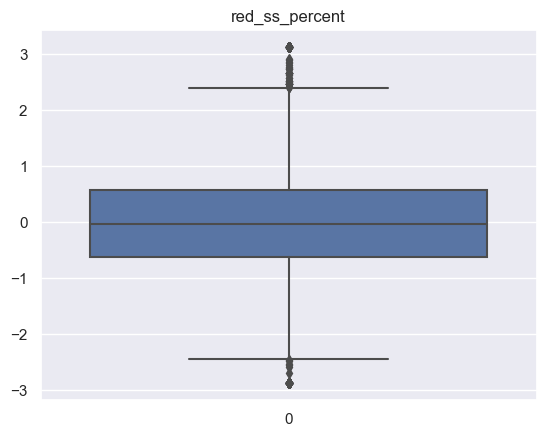

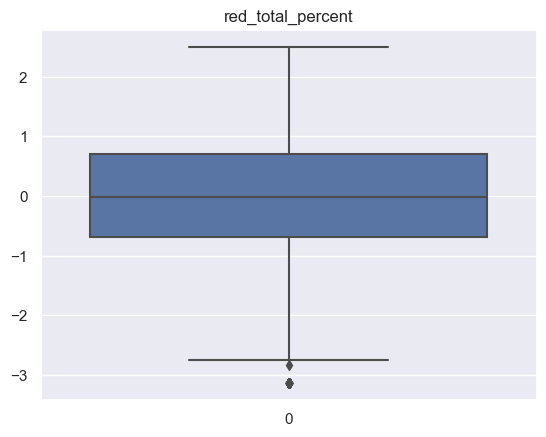

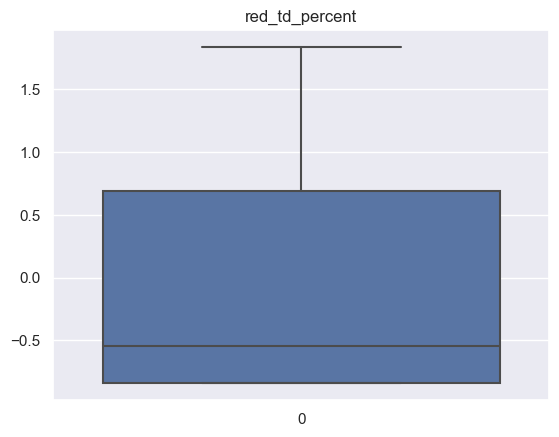

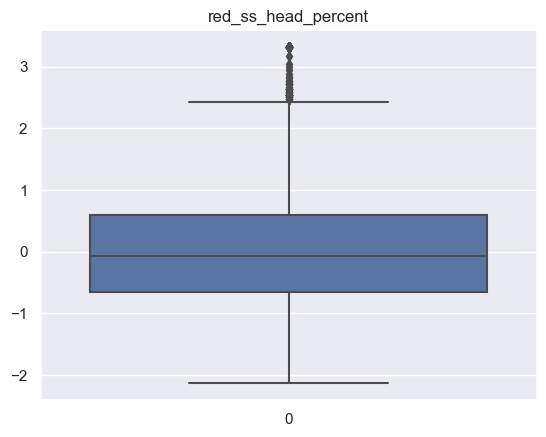

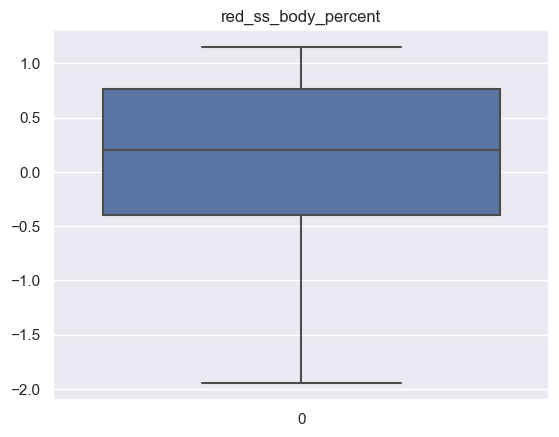

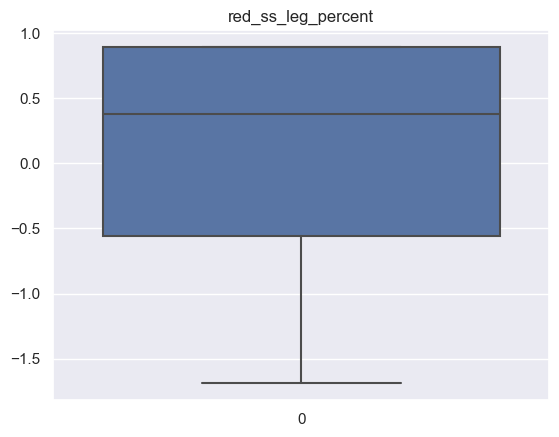

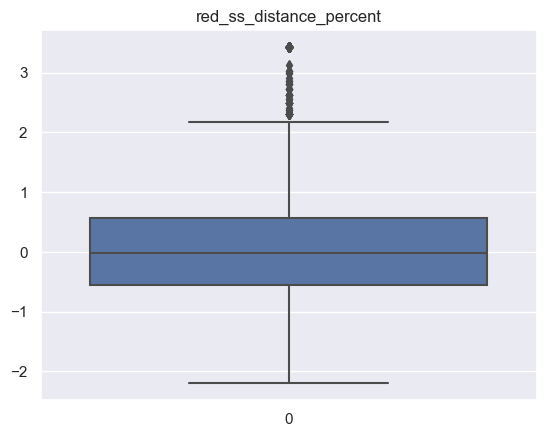

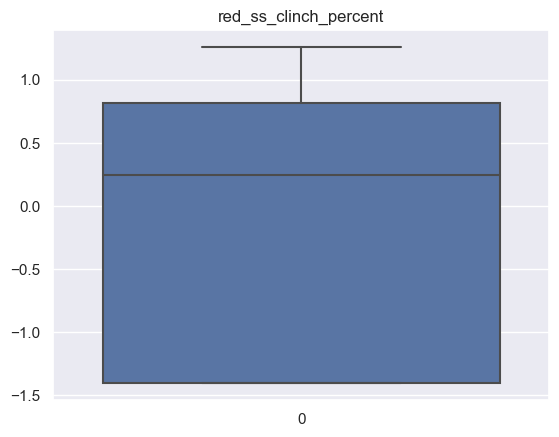

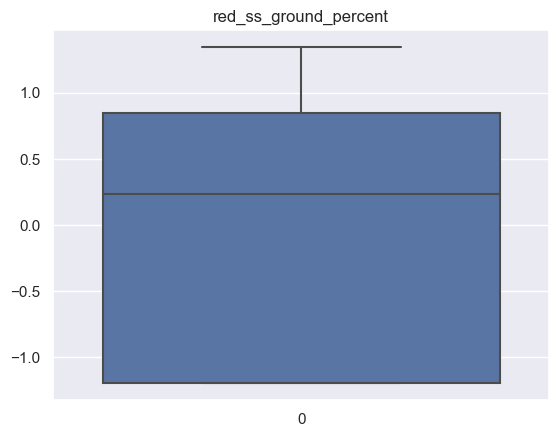

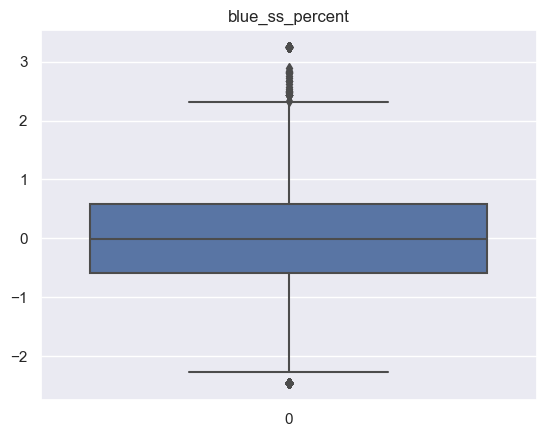

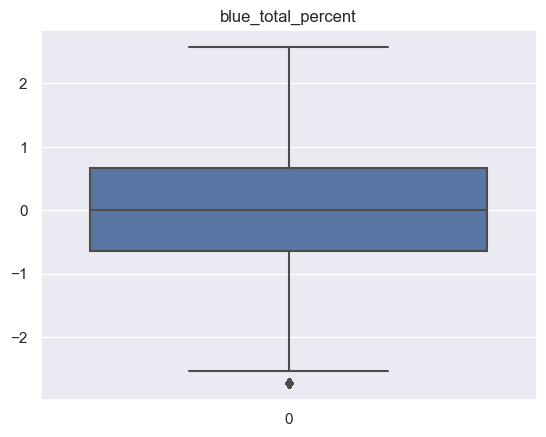

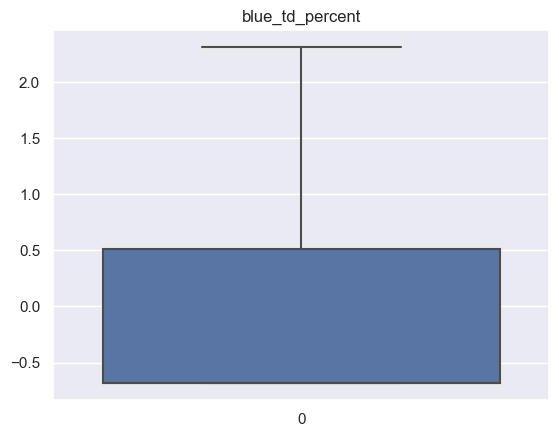

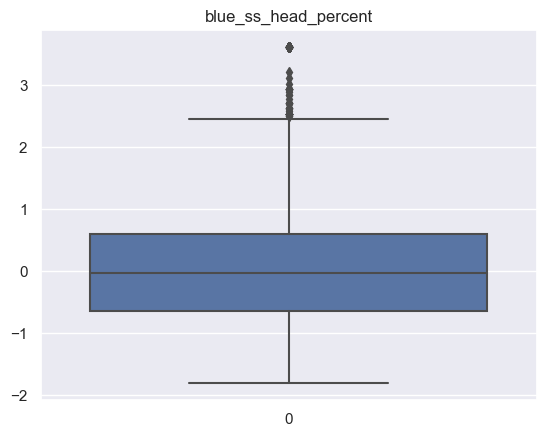

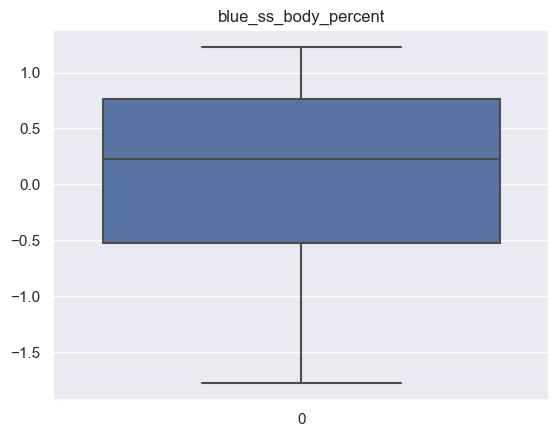

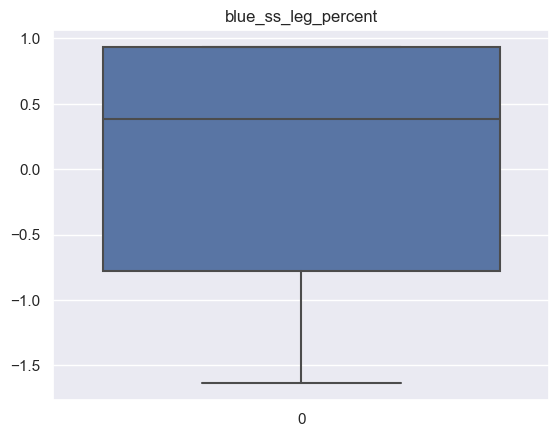

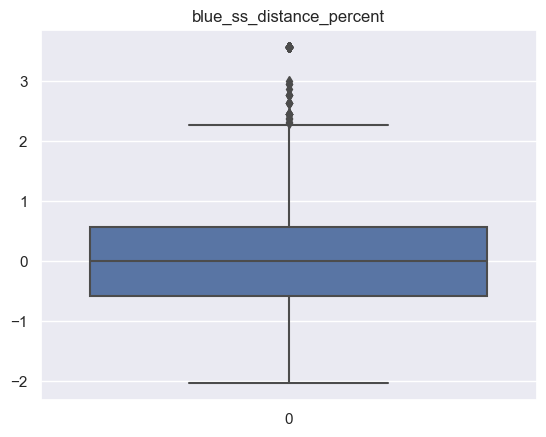

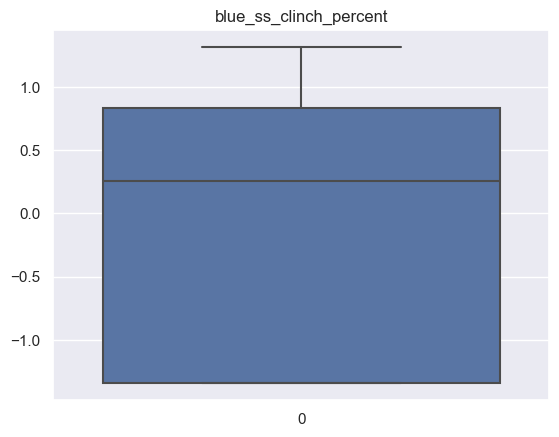

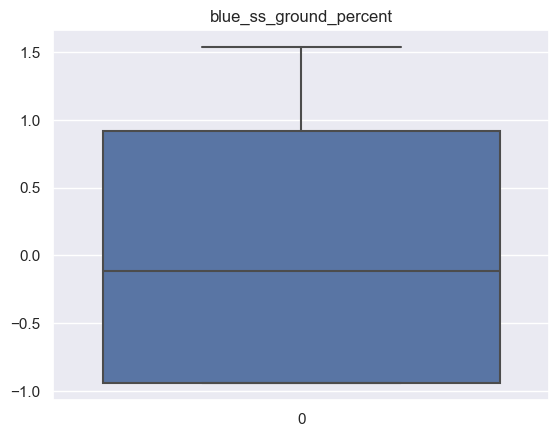

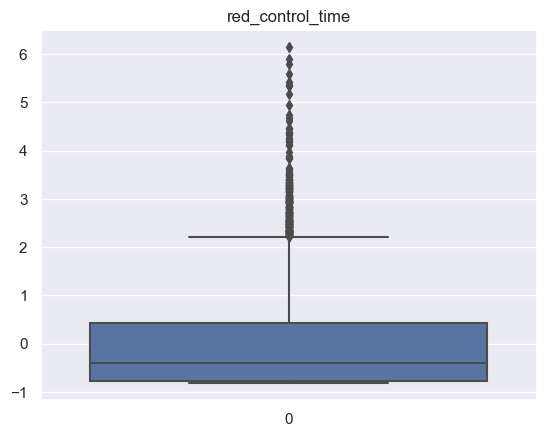

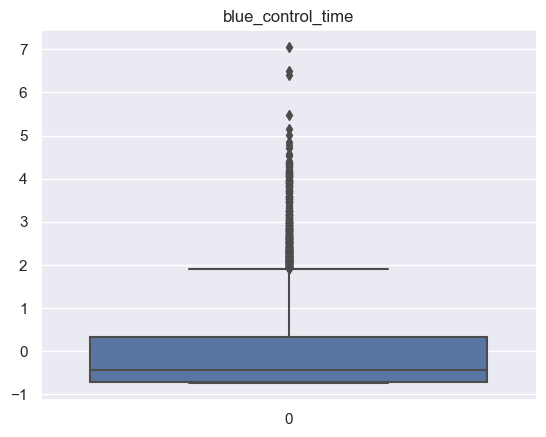

In [11]:
t = df2.select_dtypes(exclude='object')
for column in t.columns:
  if column not in ("datetime", "label", "is_draw"):
    plt.figure()
    plt.title(column)
    sb.boxplot(t[column])